FOR ORAL CANCER PREDICTION


In [147]:
import glob
import numpy as np
from PIL import Image
from numpy import array
from keras.preprocessing import image
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Dropout, BatchNormalization
# from keras.constraints import maxnorm
from keras.models import Model
from tensorflow.keras.optimizers import SGD
# from keras.utils import np_utils
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory  
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50
import keras as k
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn
from sklearn.metrics import confusion_matrix , classification_report
import joblib
import warnings
warnings.filterwarnings("ignore")

In [148]:
cancer_imgs = glob.glob('../Dataset/OralCancer/cancer' + '/*.jpg')
non_cancer_imgs = glob.glob('../Dataset/OralCancer/non-cancer/' + '/*.jpg')

In [149]:
dataset = []
labels = []

for img in cancer_imgs:
  dataset.append(image.img_to_array(image.load_img(img, target_size=(64, 64))))
  labels.append(1)

for img in non_cancer_imgs:
  dataset.append(image.img_to_array(image.load_img(img, target_size=(64, 64))))
  labels.append(0)
  
dataset = array(dataset)

Cancer Images: 


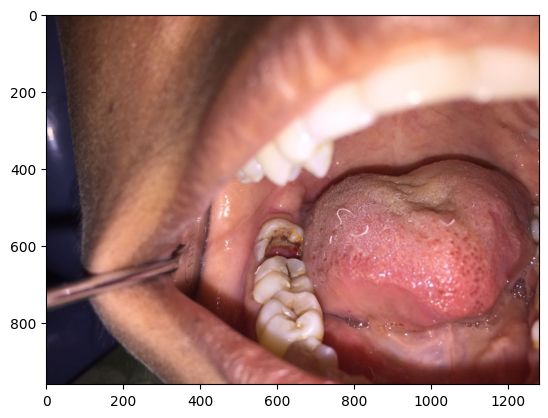

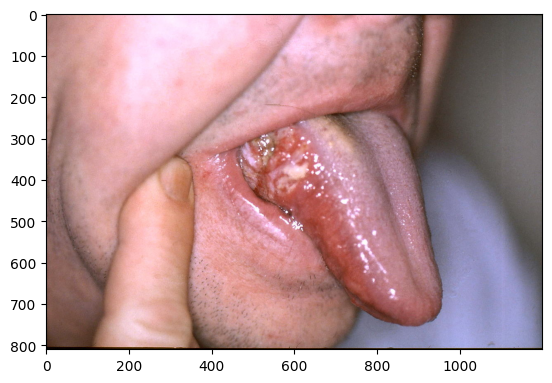

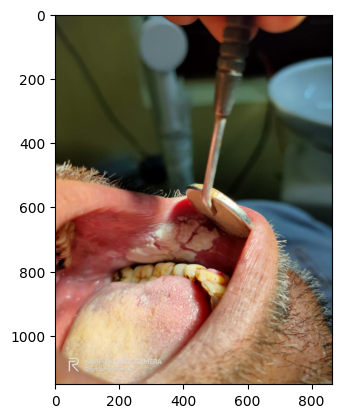

In [150]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline


print('Cancer Images: ')
for img in cancer_imgs[:3]:
  testim = mpimg.imread(img)
  plt.figure()
  imshow(testim)

In [151]:
def evaluate_model(clf, X_test, y_test, model_name):
  print('--------------------------------------------')
  print('Model ', model_name)
  y_pred = clf.predict(X_test)
  f1 = f1_score(y_test, y_pred.round(), average='weighted')
  recall = recall_score(y_test, y_pred.round(), average='weighted')
  precision = precision_score(y_test, y_pred.round(), average='weighted')
  print(classification_report(y_test, y_pred.round()))
  print("F1 Score ", f1)
  print("Recall ", recall)
  print("Precision ", precision)

In [152]:
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.25, random_state=42)
X_train = X_train.reshape(len(X_train),3*64*64)
X_test = X_test.reshape(len(X_test),3*64*64)

In [153]:

oc_clf_tree = tree.DecisionTreeClassifier(random_state=42)
oc_clf_tree = oc_clf_tree.fit(X_train, y_train)

In [154]:

sc = StandardScaler()
X2_train = sc.fit_transform(X_train)
X2_test = sc.transform(X_test)
oc_rf = RandomForestClassifier(n_estimators=2000,criterion='entropy', random_state=0)
oc_rf.fit(X2_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=2000, random_state=0)

In [155]:

oc_svm = svm.SVC(kernel='linear') # Linear Kernel
oc_svm.fit(X_train, y_train)

SVC(kernel='linear')

In [95]:
evaluate_model(oc_clf_tree, X_test, y_test, 'Decision Tree')


--------------------------------------------
Model  Decision Tree
              precision    recall  f1-score   support

           0       0.62      0.56      0.59         9
           1       0.76      0.81      0.79        16

    accuracy                           0.72        25
   macro avg       0.69      0.68      0.69        25
weighted avg       0.71      0.72      0.72        25

F1 Score  0.7160071301247772
Recall  0.72
Precision  0.7144117647058823


In [96]:
evaluate_model(oc_rf, X2_test, y_test, 'RandomForest')


--------------------------------------------
Model  RandomForest
              precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.93      0.88      0.90        16

    accuracy                           0.88        25
   macro avg       0.87      0.88      0.87        25
weighted avg       0.89      0.88      0.88        25

F1 Score  0.8812224108658744
Recall  0.88
Precision  0.8853333333333333


In [97]:
evaluate_model(oc_svm, X_test, y_test, 'SVM')

--------------------------------------------
Model  SVM
              precision    recall  f1-score   support

           0       0.64      0.78      0.70         9
           1       0.86      0.75      0.80        16

    accuracy                           0.76        25
   macro avg       0.75      0.76      0.75        25
weighted avg       0.78      0.76      0.76        25

F1 Score  0.764
Recall  0.76
Precision  0.7776623376623377


In [156]:

from tensorflow.keras.callbacks import EarlyStopping

dataset = dataset / 255.0

X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.3, random_state=42)

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

evaluate_model(model, X_test, y_test, "CNN")


Epoch 1/15
3/3 [==============================] - 2s 264ms/step - loss: 0.9385 - accuracy: 0.6571 - val_loss: 1.8335 - val_accuracy: 0.3667
Epoch 2/15
3/3 [==============================] - 1s 164ms/step - loss: 1.5177 - accuracy: 0.4857 - val_loss: 0.6697 - val_accuracy: 0.7667
Epoch 3/15
3/3 [==============================] - 1s 167ms/step - loss: 0.4654 - accuracy: 0.7714 - val_loss: 1.5419 - val_accuracy: 0.6333
Epoch 4/15
3/3 [==============================] - 1s 177ms/step - loss: 0.3901 - accuracy: 0.8286 - val_loss: 2.2669 - val_accuracy: 0.6333
Epoch 5/15
3/3 [==============================] - 1s 183ms/step - loss: 0.2626 - accuracy: 0.8857 - val_loss: 2.5933 - val_accuracy: 0.6333
Epoch 6/15
3/3 [==============================] - 0s 154ms/step - loss: 0.2586 - accuracy: 0.9143 - val_loss: 2.4718 - val_accuracy: 0.6333
Epoch 7/15
1/1 [==============================] - 0s 49ms/step - loss: 0.6697 - accuracy: 0.7667
Test Loss: 0.6697, Test Accuracy: 0.7667
----------------------

In [173]:

def load_and_convert_to_gray(img_path):
    img = Image.open(img_path).convert('L')  # 'L' mode stands for grayscale
    img_array = image.img_to_array(img.resize((64, 64)))  # Resize to desired dimensions
    return img_array

dataset = []
labels = []

s
for img in cancer_imgs:
    img_array = load_and_convert_to_gray(img)
    dataset.append(img_array)
    labels.append(1)

for img in non_cancer_imgs:
    img_array = load_and_convert_to_gray(img)
    dataset.append(img_array)
    labels.append(0)

dataset = array(dataset)
labels = np.array(labels)
labels_one_hot = to_categorical(labels, num_classes=2)

X_train, X_test, y_train, y_test = train_test_split(dataset, labels_one_hot, test_size=0.3, random_state=42)

time_steps = X_train.shape[1]
features = X_train.shape[2]

lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(time_steps, features), activation='relu', return_sequences=True))
lstm_model.add(LSTM(128, activation='relu'))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dense(2, activation='softmax'))

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lstm_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

loss_lstm, accuracy_lstm = lstm_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss_lstm:.4f}, Test Accuracy: {accuracy_lstm:.4f}')

evaluate_model(lstm_model, X_test, y_test, "LSTM")


Epoch 1/30
3/3 [==============================] - 3s 223ms/step - loss: 1832.7645 - accuracy: 0.4714 - val_loss: 9487.3174 - val_accuracy: 0.6000
Epoch 2/30
3/3 [==============================] - 0s 70ms/step - loss: 8715.8398 - accuracy: 0.5571 - val_loss: 7713.7129 - val_accuracy: 0.6000
Epoch 3/30
3/3 [==============================] - 0s 64ms/step - loss: 8888.9346 - accuracy: 0.5143 - val_loss: 22477.1152 - val_accuracy: 0.4000
Epoch 4/30
3/3 [==============================] - 0s 72ms/step - loss: 13117.9287 - accuracy: 0.5429 - val_loss: 19545.9883 - val_accuracy: 0.4333
Epoch 5/30
3/3 [==============================] - 0s 61ms/step - loss: 14477.2520 - accuracy: 0.5143 - val_loss: 25357.7910 - val_accuracy: 0.3000
Epoch 6/30
3/3 [==============================] - 0s 74ms/step - loss: 14447.6143 - accuracy: 0.5286 - val_loss: 8455.3203 - val_accuracy: 0.6667
Epoch 7/30
1/1 [==============================] - 0s 31ms/step - loss: 7713.7129 - accuracy: 0.6000
Test Loss: 7713.7129, T

In [158]:
#import our data
train_datagen = ImageDataGenerator(
    rescale=1. / 255,rotation_range=10, fill_mode='nearest',
     featurewise_center=True,
    featurewise_std_normalization=True,
    vertical_flip= True,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range = (0.4,0.6),
    horizontal_flip=True,validation_split=0.3)

In [159]:
train_generator = train_datagen.flow_from_directory(
    '../Dataset/OralCancer/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',subset='training'
  )

Found 92 images belonging to 2 classes.


In [160]:
test_generator = train_datagen.flow_from_directory(
     '../Dataset/OralCancer/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',subset='validation'
    
  )

Found 39 images belonging to 2 classes.


In [ ]:
train_dataset = image_dataset_from_directory('../Dataset/OralCancer/',
                                             shuffle=True,
                                             batch_size=32,image_size=(224,224))
class_name =  train_dataset.class_names
plt.figure(figsize = (10,10))
for image , label in train_dataset.take(1):
    for i in range(9) :
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_name[label[i]])
        plt.axis("off")

In [162]:
res_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=k.Input(shape=(224,224,3)),
)
for models in res_model.layers[:-1]:
      models.trainable= False
model = k.models.Sequential()
model.add(res_model)
model.add(k.layers.Flatten())
model.add(k.layers.Dense(4, activation='softmax'))
print(model.summary())

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_13 (Flatten)        (None, 100352)            0         
                                                                 
 dense_66 (Dense)            (None, 4)                 401412    
                                                                 
Total params: 23989124 (91.51 MB)
Trainable params: 401412 (1.53 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
None


In [163]:
model.compile(optimizer="adam", loss=k.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [164]:
FIT =model.fit(train_generator,
    validation_data = test_generator, 
    callbacks = [early],
    epochs = 5)

Epoch 1/5
3/3 [==============================] - 11s 3s/step - loss: 5.4745 - accuracy: 0.5761 - val_loss: 5.4076 - val_accuracy: 0.6667
Epoch 2/5
3/3 [==============================] - 7s 2s/step - loss: 4.4285 - accuracy: 0.5543 - val_loss: 5.6717 - val_accuracy: 0.3333
Epoch 3/5
3/3 [==============================] - 7s 2s/step - loss: 3.1200 - accuracy: 0.4891 - val_loss: 3.1995 - val_accuracy: 0.6667
Epoch 4/5
3/3 [==============================] - 6s 2s/step - loss: 3.4551 - accuracy: 0.6630 - val_loss: 2.6915 - val_accuracy: 0.6667
Epoch 5/5
3/3 [==============================] - 6s 2s/step - loss: 1.7991 - accuracy: 0.5761 - val_loss: 2.5164 - val_accuracy: 0.3333


In [165]:
class_name = {0:"cancer",1:"non cancer"}

In [166]:
y = model.predict(test_generator)
y =  np.argmax(y,axis= 1 )

2/2 [==============================] - 3s 373ms/step


In [170]:
y_true = np.array([])
y_pred = np.array([])

i = 0
for data, labels in test_generator:
    i += 1
    y = np.argmax(model.predict(data), axis=1)
    y_true = np.append(y_true, labels)
    y_pred = np.append(y_pred, y)
  
    if i == test_generator.samples // 32 + 1:
        break

1/1 [==============================] - 0s 361ms/step


In [171]:
f1 = f1_score(y_pred, y_true, average='weighted')
precision = precision_score(y_pred, y_true, average='weighted')
print("F1 Score ", f1)
print("Precision ", precision)

F1 Score  0.5
Precision  1.0
